# Zonal Analysis

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import rasterio as rio
import swisslandstats as sls
from shapely.geometry import Point

import pylandstats as pls

Landscapes tend to be heterogeneous and complex and therefore reducing such information to a single scalar value for all the landscape often leads to metric values that are hard to interpret. It might thus be helpful to decompose the landscape into a set of zones of interest and compute the metrics for each zone separatedly. Such approach to GIS is often referred to as zonal analysis. The PyLandStats library features three classes that might be used to that end: the more generic `ZonalAnalysis`, `BufferAnalysis` and `ZonalGridAnalysis`.

We first need to run the cell below so that the land use/land cover (LULC) data is downloaded and preprocessed (see [A03-swisslandstats-preprocessing.ipynb](https://github.com/martibosch/pylandstats-notebooks/blob/master/notebooks/A03-swisslandstats-preprocessing.ipynb) for more details).

In [ ]:
!make -C .. lulc_rasters

Consider the following landscape of the Veveysee District, Switzerland:

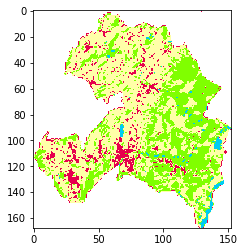

In [ ]:
URBAN_CLASS_VAL = 1
input_filepath = "../data/processed/veveyse-AS18_4.tif"

with rio.open(input_filepath) as src:
    plt.imshow(src.read(1), cmap=sls.noas04_4_cmap)

Landscape metrics are very sensitive to the spatial extent of the map. Therefore, when evaluating the landscape patterns in urban areas (red pixels), the computed values for the metrics would strongly depend on how an urban area is defined. In order to overcome such issue, landscape studies often study how metrics vary for a set of spatial extents along the urban-rural gradient.

## Zonal analysis

The `ZonalAnalysis` class of PyLandStats serves to compute the landscape metrics over any set of zones, which can be defined by means of raster or vector geometries.

### Using raster masks to define zones

The zones can be defined as NumPy boolean arrays of the same shape of the landscape of interest. For instance, in order to compute the metrics over a set of rectangular transects, let us define three transects of 50x50 cells (5x5km) that horizontally traverse our landscape at the latitude of Chatel-St-Denis:

In [ ]:
with rio.open(input_filepath) as src:
    base_mask_arr = np.full(src.shape, False)

masks = []
transect_len = 50
for transect_start in range(0, 150, transect_len):
    mask_arr = np.copy(base_mask_arr)
    mask_arr[80:130, transect_start : transect_start + transect_len] = True
    masks.append(mask_arr)

This is how the mask of each transect looks:

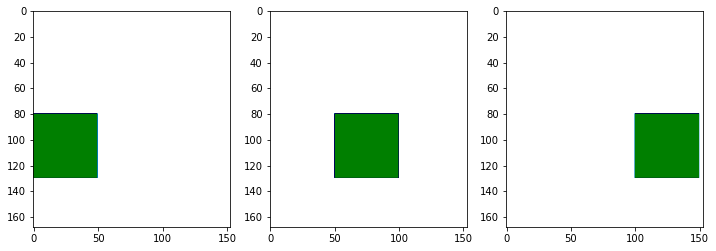

In [ ]:
num_subplots = len(masks)
fig = plt.figure(figsize=(num_subplots * 4, 4))
# better colormap to plot mask arrays
mask_cmap = plt.get_cmap("ocean_r")

for i in range(num_subplots):
    ax = fig.add_subplot(1, num_subplots, i + 1)
    ax.imshow(masks[i], cmap=mask_cmap)

We will now use the `ZonalAnalysis` class with the list of mask arrays (corresponding to the transects) that we have constructed above. We can use the keyword argument `attribute_values` to map an identifying value or label to each of our landscapes. 

Here we will use strings that denote that each landscape corresponds to the transect from kilometers 0 to 5, 5 to 10 and 10 to 15 respectively. But we could have used any other list-like argument as long as it is consistent with the number of mask arrays provided through the `masks` argument.

In [ ]:
za = pls.ZonalAnalysis(
    input_filepath, masks=masks, attribute_values=["0-5", "5-10", "10-15"]
)

The `ZonalAnalysis` instance will automatically generate the three landscapes of interest (one for each transect) by masking the pixels of the input raster, which can be visualized by means of the `plot_landscapes` method as in:

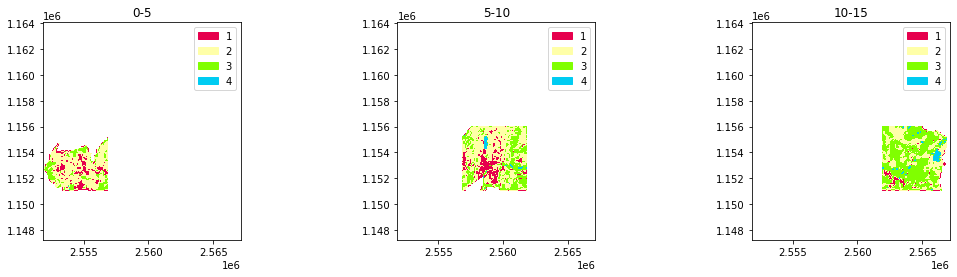

In [ ]:
fig = za.plot_landscapes(cmap=sls.noas04_4_cmap)

And we can now compute and plot the landscape metrics for each of the transect landscapes.

Like `SpatioTemporalAnalysis`, `ZonalAnalysis` only supports class and landscape-level metrics, which again, can be computed by means of its methods `compute_class_metrics_df` and `compute_landscape_metrics_df` respectively, e.g.:

In [ ]:
za.compute_class_metrics_df()

metric                      total_area  proportion_of_landscape  \
class_val attribute_values                                        
1         0-5                    206.0                14.167813   
          5-10                   333.0                14.092256   
          10-15                   86.0                 3.752182   
2         0-5                    968.0                66.574966   
          5-10                  1347.0                57.003809   
          10-15                  836.0                36.474695   
3         0-5                    278.0                19.119670   
          5-10                   646.0                27.338129   
          10-15                 1297.0                56.588133   
4         0-5                      2.0                 0.137552   
          5-10                    37.0                 1.565806   
          10-15                   73.0                 3.184991   

metric                      number_of_patches  patch_density  \
class_val attribute_values                                     
1         0-5                            45.0       3.094911   
          5-10                           47.0       1.988997   
          10-15                          34.0       1.483421   
2         0-5                            11.0       0.756534   
          5-10                           20.0       0.846382   
          10-15                          27.0       1.178010   
3         0-5                            43.0       2.957359   
          5-10                           65.0       2.750741   
          10-15                          14.0       0.610820   
4         0-5                             2.0       0.137552   
          5-10                           11.0       0.465510   
          10-15                          23.0       1.003490   

metric                      largest_patch_index  total_edge  edge_density  \
class_val attribute_values                                                  
1         0-5                          3.232462     45800.0     31.499312   
          5-10                         8.082945     66200.0     28.015235   
          10-15                        0.916230     22900.0      9.991274   
2         0-5                         64.649243     80900.0     55.639615   
          5-10                        41.261109    143900.0     60.897165   
          10-15                       13.612565    102200.0     44.589878   
3         0-5                          4.745530     41800.0     28.748281   
          5-10                         9.267880    104100.0     44.054168   
          10-15                       53.403141    111100.0     48.472949   
4         0-5                          0.068776       700.0      0.481431   
          5-10                         0.973339      7400.0      3.131612   
          10-15                        1.832461     14800.0      6.457243   

metric                      landscape_shape_index  effective_mesh_size  \
class_val attribute_values                                               
1         0-5                            8.206897             3.623109   
          5-10                           9.135135            15.994499   
          10-15                          6.105263             0.440663   
2         0-5                            7.396825           607.778542   
          5-10                          10.432432           417.654253   
          10-15                          9.775862            84.273124   
3         0-5                            7.382353             6.092160   
          5-10                          11.274510            31.104528   
          10-15                          8.232877           654.201134   
4         0-5                            1.333333             0.001376   
          5-10                           3.076923             0.235717   
          10-15                          4.333333             0.792757   

metric                        area_mn  ...  frac

Likewise `SpatioTemporalAnalysis`, if we want to compute the metrics data frame only for a subset of metrics or classes, or customize how the metrics are computed, we must pass the arguments `metrics`, `classes` or `metrics_kws` to the `compute_class_metrics_df` and `compute_landscape_metrics_df`, as in:
<a id='customizing-zonal-analysis'></a>

In [ ]:
metrics = ["proportion_of_landscape", "edge_density", "fractal_dimension_am"]
classes = [URBAN_CLASS_VAL]
metrics_kws = {
    "proportion_of_landscape": {"percent": False},
    "edge_density": {"count_boundary": True},
}
za.compute_class_metrics_df(
    metrics=metrics, classes=[URBAN_CLASS_VAL], metrics_kws=metrics_kws
)

metric                      proportion_of_landscape  edge_density  \
class_val attribute_values                                          
1         0-5                              0.141678     32.737276   
          5-10                             0.140923     28.607702   
          10-15                            0.037522     10.122164   

metric                      fractal_dimension_am  
class_val attribute_values                        
1         0-5                           1.111419  
          5-10                          1.160041  
          10-15                         1.074845

On the other hand, the `plot_metric` method of `ZonalAnalysis` will plot the value of a given metric for each of the buffered landscapes:

<AxesSubplot:ylabel='PLAND'>

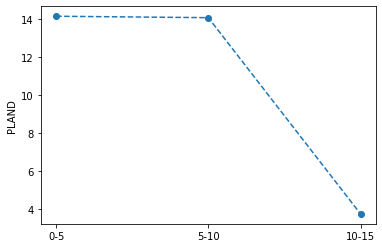

In [ ]:
za.plot_metric("proportion_of_landscape", class_val=URBAN_CLASS_VAL)

Note that the values that we pass to `attribute_values` when initializing the `ZonalAnalysis` are used within the metric dataframes and plot labels.

In order to visualize such information in space, the zonal statistics can be computed in the form of a two-dimensional array with the `compute_zonal_statistics_arr` method as in:

In [ ]:
zonal_statistics_arr = za.compute_zonal_statistics_arr(
    "proportion_of_landscape", class_val=URBAN_CLASS_VAL
)

which returns an array of the same form as the input landscape.

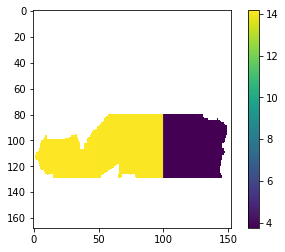

In [ ]:
plt.imshow(zonal_statistics_arr)
plt.colorbar()

We can see that the highest proportion of urban land cover is found in the western and central transects, which actually correspond to the town of Chatel-St-Denis.

A zonal statistics array can be dumped into a GeoTiff raster file by means of the the `dst_filepath` argument of `compute_zonal_statistics_arr` as in:

In [ ]:
_ = za.compute_zonal_statistics_arr(
    "proportion_of_landscape",
    class_val=URBAN_CLASS_VAL,
    dst_filepath="pland-transects.tif",
)

### Using vector geometries to define zones

We can also use vector geometries to define zones, such as a shapefile of elevation zones.

In [ ]:
dem_filepath = "../data/raw/dem/dem.gpkg"

za = pls.ZonalAnalysis(input_filepath, masks=dem_filepath, masks_index_col="elev")

We can then compute data frames of metrics, e.g.:

In [ ]:
class_metrics_df = za.compute_class_metrics_df(metrics=["proportion_of_landscape"])
class_metrics_df

metric           proportion_of_landscape
class_val elev                          
1         500.0                 0.000000
          700.0                 5.208333
          900.0                 0.000000
2         500.0                76.923077
          700.0                78.125000
          900.0                28.571429
3         500.0                23.076923
          700.0                15.625000
          900.0                71.428571
4         500.0                 0.000000
          700.0                 1.041667
          900.0                 0.000000

In this case we see how the proportion of urbanized landscape (class `1`) becomes zero at highest altitudes.

## Buffer Analysis

In line with the classic concentric models of location and land use, we are often interested in evaluate how the landscape patterns change as we move away from the urban center. To that end, PyLandStats features the `BufferAnalysis` class (which inherits from the `ZonalAnalysis` class), which defines a series of spatial extents for our landscape based on buffers of increasing distances around our feature of interest - in this example, the town of Chatel-St-Denis.

### From Point

We might define a given coordinate as the center of our region of interest (in this example, the town of Chatel-St-Denis) and a series of buffer distances around that point:

In [ ]:
# latitude and longitude of the center of Chatel-St-Denis according to OpenStreetMap
base_mask = Point(6.8992073, 46.52634)
base_mask_crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

# buffer distances (in meters)
buffer_dists = [2000, 4000, 6000]

then, we can use the `BufferAnalysis` class of Pylandstats as in (note that we need to provide the CRS of the geometry - in this example, the coordinate point):

In [ ]:
ba = pls.BufferAnalysis(
    input_filepath, base_mask, buffer_dists, base_mask_crs=base_mask_crs
)

The `BufferAnalysis` instance will automatically generate the three landscapes of interest (one for each buffer distance) by masking the pixels of the input raster:

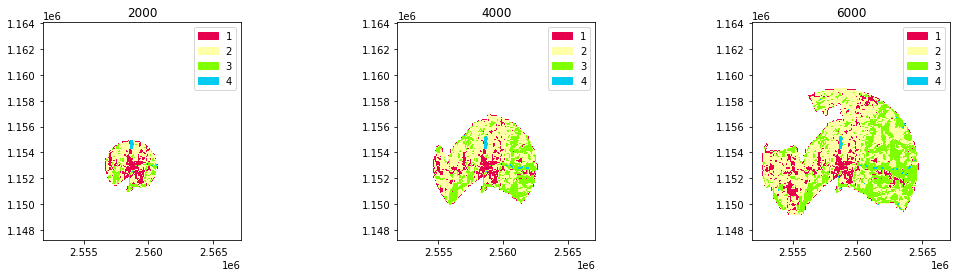

In [ ]:
fig = ba.plot_landscapes(cmap=sls.noas04_4_cmap)

Likewise `ZonalAnalysis`, we can compute the landscap metrics for each buffer distance with the `compute_class_metrics_df` and `compute_landscape_metrics_df` methods, e.g.:

In [ ]:
ba.compute_class_metrics_df()

metric                  total_area  proportion_of_landscape  \
class_val buffer_dists                                        
1         2000               281.0                24.224138   
          4000               469.0                12.727273   
          6000               785.0                10.910354   
2         2000               664.0                57.241379   
          4000              2090.0                56.716418   
          6000              4042.0                56.177901   
3         2000               193.0                16.637931   
          4000              1088.0                29.525102   
          6000              2303.0                32.008339   
4         2000                22.0                 1.896552   
          4000                38.0                 1.031208   
          6000                65.0                 0.903405   

metric                  number_of_patches  patch_density  largest_patch_index  \
class_val buffer_dists                                                          
1         2000                       25.0       2.155172            16.465517   
          4000                       75.0       2.035278             5.183175   
          6000                      158.0       2.195969             2.654621   
2         2000                       11.0       0.948276            43.793103   
          4000                       24.0       0.651289            45.210312   
          6000                       42.0       0.583739            46.309937   
3         2000                       41.0       3.534483             3.965517   
          4000                       89.0       2.415197            10.719132   
          6000                      143.0       1.987491            20.625434   
4         2000                        7.0       0.603448             1.379310   
          4000                       11.0       0.298507             0.624152   
          6000                       32.0       0.444753             0.319666   

metric                  total_edge  edge_density  landscape_shape_index  \
class_val buffer_dists                                                    
1         2000             50900.0     43.879310               7.647059   
          4000             97700.0     26.512890              11.522727   
          6000            170300.0     23.669215              15.210526   
2         2000             76000.0     65.517241               8.365385   
          4000            213100.0     57.829037              12.489130   
          6000            394500.0     54.829743              16.492188   
3         2000             38700.0     33.362069               7.892857   
          4000            151300.0     41.058345              12.818182   
          6000            293500.0     40.792217              16.916667   
4         2000              3800.0      3.275862               2.200000   
          4000              7700.0      2.089552               3.153846   
          6000             16900.0      2.348853               5.411765   

metric                  effective_mesh_size    area_mn  ...  \
class_val buffer_dists                                  ...   
1         2000                    32.356034  11.240000  ...   
          4000                    11.015197   6.253333  ...   
          6000                     6.971369   4.968354  ...   
2         2000                   228.406897  60.363636  ...   
          4000                   764.736499  87.083333  ...   
          6000                  1559.026824  96.238095  ...   
3         2000                     3.295690   4.707317  ...   
          4000                    60.189417  12.224719  ...   
          6000                   314.360111  16.104895  ...   
4         2000                     0.225862   3.142857  ...   
          4000                     0.151967   3.454545  ...   
          6000                     0.083530   2.031250  ...   

metric                  fractal_dimension_md  fr

Note that the data frames for `BufferAnalysis`, likewise those of `SpatioTemporalAnalysis` or `ZonalAnalysis` (see [above](#customizing-zonal-analysis)) can be customized via by passing the arguments `metrics`, `classes` or `metrics_kws` to the `compute_class_metrics_df` and `compute_landscape_metrics_df` methods.

The `plot_metric` method of `BufferAnalysis` will plot the value of a given metric for each of the buffered landscapes:

<AxesSubplot:ylabel='PLAND'>

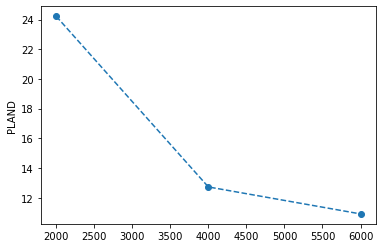

In [ ]:
ba.plot_metric("proportion_of_landscape", class_val=URBAN_CLASS_VAL)

The specific plot above shows how the proportion of landscape (y-axis) occupied by urban land uses diminishes with the buffer distance (x-axis) around the feature of interest (i.e., the city center of Chatel-St-Denis).

To examine more closely how landscape patterns change as we move along the urban-rural gradient, we might actually want to compute the metrics for each of the buffer rings that lie within each pair of increasing buffer distances. For instance, for the buffer distances considered in this example (i.e., 2000, 4000 and 6000), we would like to compute the metrics for the buffer rings that go from 0 to 2000m, 2000 to 4000m and 4000 to 6000m around the center of Chatel-St-Denis).

To that end, we might pass the argument `buffer_rings=True` when instantiating `BufferAnalysis` as in:

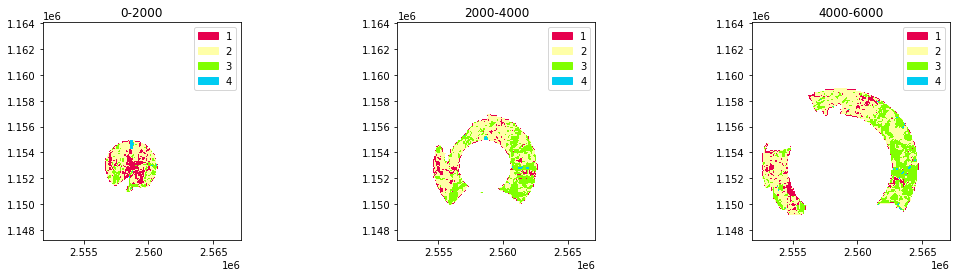

In [ ]:
ba = pls.BufferAnalysis(
    input_filepath,
    base_mask,
    buffer_dists,
    buffer_rings=True,
    base_mask_crs=base_mask_crs,
)
fig = ba.plot_landscapes(cmap=sls.noas04_4_cmap)

In [ ]:
ba.compute_class_metrics_df()

metric                  total_area  proportion_of_landscape  \
class_val buffer_dists                                        
1         0-2000             281.0                24.224138   
          2000-4000          188.0                 7.445545   
          4000-6000          316.0                 9.002849   
2         0-2000             664.0                57.241379   
          2000-4000         1426.0                56.475248   
          4000-6000         1952.0                55.612536   
3         0-2000             193.0                16.637931   
          2000-4000          895.0                35.445545   
          4000-6000         1215.0                34.615385   
4         0-2000              22.0                 1.896552   
          2000-4000           16.0                 0.633663   
          4000-6000           27.0                 0.769231   

metric                  number_of_patches  patch_density  largest_patch_index  \
class_val buffer_dists                                                          
1         0-2000                     25.0       2.155172            16.465517   
          2000-4000                  52.0       2.059406             1.544554   
          4000-6000                  93.0       2.649573             1.794872   
2         0-2000                     11.0       0.948276            43.793103   
          2000-4000                  19.0       0.752475            45.584158   
          4000-6000                  31.0       0.883191            28.888889   
3         0-2000                     41.0       3.534483             3.965517   
          2000-4000                  59.0       2.336634            14.772277   
          4000-6000                  64.0       1.823362            15.584046   
4         0-2000                      7.0       0.603448             1.379310   
          2000-4000                   6.0       0.237624             0.277228   
          4000-6000                  21.0       0.598291             0.085470   

metric                  total_edge  edge_density  landscape_shape_index  \
class_val buffer_dists                                                    
1         0-2000           50900.0     43.879310               7.647059   
          2000-4000        45600.0     18.059406               8.857143   
          4000-6000        70500.0     20.085470              10.472222   
2         0-2000           76000.0     65.517241               8.365385   
          2000-4000       132400.0     52.435644              10.223684   
          4000-6000       176400.0     50.256410              11.550562   
3         0-2000           38700.0     33.362069               7.892857   
          2000-4000       108600.0     43.009901              10.650000   
          4000-6000       137800.0     39.259259              11.671429   
4         0-2000            3800.0      3.275862               2.200000   
          2000-4000         3600.0      1.425743               2.625000   
          4000-6000         8900.0      2.535613               4.636364   

metric                  effective_mesh_size    area_mn  ...  \
class_val buffer_dists                                  ...   
1         0-2000                  32.356034  11.240000  ...   
          2000-4000                1.135842   3.615385  ...   
          4000-6000                1.929915   3.397849  ...   
2         0-2000                 228.406897  60.363636  ...   
          2000-4000              532.213069  75.052632  ...   
          4000-6000              409.884330  62.967742  ...   
3         0-2000                   3.295690   4.707317  ...   
          2000-4000               74.527129  15.169492  ...   
          4000-6000              105.799715  18.984375  ...   
4         0-2000                   0.225862   3.142857  ...   
          2000-4000                0.028515   2.666667  ...   
          4000-6000                0.011681   1.285714  ...   

metric                  fractal_dimension_md  fr

<AxesSubplot:ylabel='PLAND'>

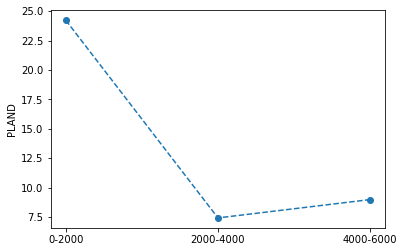

In [ ]:
ba.plot_metric("proportion_of_landscape", class_val=URBAN_CLASS_VAL)

Again, the zonal statistics of a metric can be represented in space with of the `compute_zonal_statistics_arr` method:

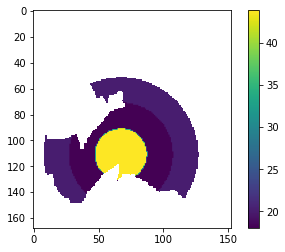

In [ ]:
zonal_statistics_arr = ba.compute_zonal_statistics_arr(
    "edge_density", class_val=URBAN_CLASS_VAL
)
plt.imshow(zonal_statistics_arr)
plt.colorbar()

and further dump it to a raster file by providing the `dst_filepath` argument.

### From Polygon

We might as well build our buffer zones from polygon geometries such as administrative boundaries

<AxesSubplot:>

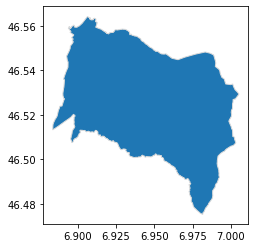

In [ ]:
gdf = ox.geocode_to_gdf("Chatel-St-Denis, Switzerland")
base_mask = gdf.geometry
base_mask.plot()

Note that in this case, since we are working with a GeoSeries that has a CRS defined, we do not need to set it explicitly with the `base_mask_crs` argument.

In [ ]:
base_mask.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Also note that since in this case our base mask from which we will define buffer zones is already a polygon. Therefore, we might want to start from smaller buffer distances, even from zero, so that we start computing the metrics for the region defined by the polygon itself (in our example, the administrative boundaries)

In [ ]:
buffer_dists = [0, 2000, 4000]

In [ ]:
ba = pls.BufferAnalysis(input_filepath, base_mask, buffer_dists)

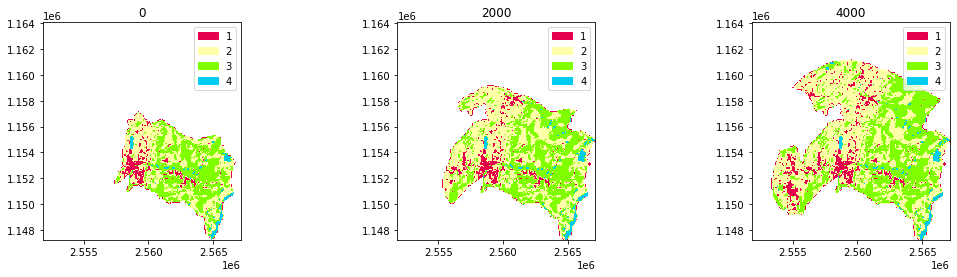

In [ ]:
fig = ba.plot_landscapes(cmap=sls.noas04_4_cmap)

<AxesSubplot:ylabel='PLAND'>

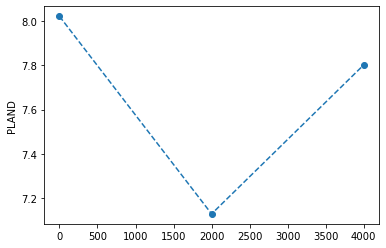

In [ ]:
ba.plot_metric("proportion_of_landscape", class_val=URBAN_CLASS_VAL)

## Zonal Grid Analysis

Another recurrent approach to zonal analysis is to decompose the landscape raster into a coarser grid and compute the landscape metrics for each zone cell. This is the purpose of the `ZonalGridAnalysis` class (which also inherits from `ZonalAnalysis`). We can instantiate it by providing the number of landscape pixels that we desire in each zone cell as in:

In [ ]:
zone_pixel_width, zone_pixel_height = 10, 10

zga = pls.ZonalGridAnalysis(
    input_filepath,
    zone_pixel_width=zone_pixel_width,
    zone_pixel_height=zone_pixel_height,
)

Alternatively, we can instead define the number of zones that we desire in each dimension by means of the `num_zone_rows` and `num_zone_cols` keyword arguments of the initialization method.

The `ZonalGridAnalysis` class will automatically discard all the zone cells that have no data in the original raster. We can visualize the zonal grid (in random grid cell colors) as in:

<AxesSubplot:>

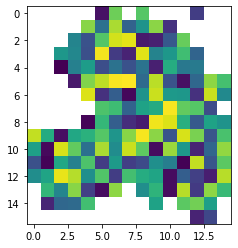

In [ ]:
zga.plot_landscapes()

The `compute_class_metrics_df` and `compute_landscape_metrics_df` class operate exactly like in the other classes:

In [ ]:
zga.compute_class_metrics_df(metrics=metrics, classes=[URBAN_CLASS_VAL])

metric              proportion_of_landscape  edge_density  \
class_val zones                                             
1         (0, 5)                   6.666667     16.666667   
          (0, 6)                   2.127660      8.510638   
          (0, 8)                   0.000000      0.000000   
          (0, 12)                  0.000000      0.000000   
          (1, 4)                   3.846154     11.538462   
...                                     ...           ...   
          (14, 11)                 0.000000      0.000000   
          (14, 12)                 1.000000      4.000000   
          (14, 13)                 0.000000      0.000000   
          (15, 12)                 1.515152      4.545455   
          (15, 13)                 0.000000      0.000000   

metric              fractal_dimension_am  
class_val zones                           
1         (0, 5)                     1.0  
          (0, 6)                     1.0  
          (0, 8)                     NaN  
          (0, 12)                    NaN  
          (1, 4)                     1.0  
...                                  ...  
          (14, 11)                   NaN  
          (14, 12)                   1.0  
          (14, 13)                   NaN  
          (15, 12)                   1.0  
          (15, 13)                   NaN  

[168 rows x 3 columns]

Note that the data frames are now indexed by a list of tuples that correspond to the row, column location of each zone. The `NaN` rows thus correspond to zones with no pixels of `URBAN_CLASS_VAL`.

Like in the other zonal analysis classes, the zonal metrics van be represented in space by means of the `compute_zonal_statistics_arr` method. For instance, we can view the spatial distribution of the edge density at the landscape level as in:

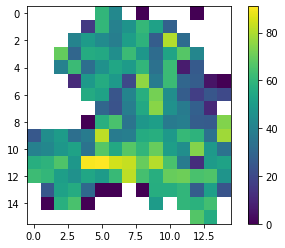

In [ ]:
ed_zgs_arr = zga.compute_zonal_statistics_arr("edge_density")

plt.imshow(ed_zgs_arr)
plt.colorbar()

Again, we could provide a file path as the `dst_filepath` argument to dump such result into a raster file.

## See also

* [SpatioTemporalBufferAnalysis](https://github.com/martibosch/pylandstats-notebooks/blob/master/notebooks/04-spatiotemporal-buffer-analysis.ipynb)